### Introduction

Climate change will have particularly severe implications for changes in the frequency and intensity of extreme weather events including floods. Given the threat extreme weather can impose to our society, it is especially important for us to have a proper definition for an "extreme" event. A more thorough discussion on the subject can be found in [Ralph and Dettinger (2012)](http://journals.ametsoc.org/doi/abs/10.1175/BAMS-D-11-00188.1).

In this notebook we will demonstrate how to calculate an extreme precipitation indicator
using the [pandas](http://pandas.pydata.org/) library. Such work is an important part of the ongoing U.S. National Climate Assessment ([NCA](http://www.globalchange.gov/what-we-do/assessment)). 

### Prerequisites

Before running this notebook, you will need to have the following:

#### Dependencies
Our main required dependencies are **geopandas** for data processing and (optionally) **matplotlib** for visualizing our results. **netCDF4** will be useful for loading your own datasets as well as providing us some datetime utilities. If you do not already have them installed, we recommend using [conda](https://conda.io/miniconda.html):

```
conda config --add channels conda-forge 
conda install geopandas matplotlib
```

#### Data
You will need U.S. states [boundary data](http://eric.clst.org/Stuff/USGeoJSON), preferably in GeoJSON format. Optionally, you may also want to use a real daily precipitation dataset (such as [TRMM](https://disc.sci.gsfc.nasa.gov/uui/datasets/TRMM_3B42_daily_V7/summary) or [PRISM](prism.oregonstate.edu)), but it is not needed to run the example in this notebook.

### Initial Setup
First, let's import our required libraries:

In [138]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.tools import sjoin
from netCDF4 import num2date
from shapely.geometry import Point

Next we will need to extract the dimensions of our data, which should span the contiguous U.S. for at least a year. If you are using a real dataset loaded from a netcdf file, use the latitude and longitude arrays it provides instead. Otherwise, edit these numbers as needed if you wish to benchmark larger workloads.

In [139]:
# initial lat/lon arrays
lat_min, lat_max, dlat = 24, 50, 0.5
lon_min, lon_max, dlon = -125, -65, 0.5
lons = np.arange(lon_min, lon_max + 1, dlat)
lats = np.arange(lat_min, lat_max + 1, dlon)

# dimensions of the data
nlats = lats.size
nlons = lons.size

# Rectangular grid
lons, lats = np.meshgrid(lons, lats)

# Time information
ndays = 731
years = [date.year for date in num2date(np.arange(ndays), 'days since 2000-01-01')]

### Part 1: Calculating the Extreme Precipitation Index (P-Cat)

We are now ready to wrap our data inside a DataFrame object. Be sure to squash the spatial dimensions into one, as our input should have dimensions of (day, gridpoint). 

In [140]:
npoints = nlats*nlons
# If you are using your own dataset replace the following line
data = np.linspace(0, 200, ndays*npoints).reshape(ndays, npoints)
precip = pd.DataFrame(data, index=years)
precip[:10]

,0,1,2,3,4,5,6,7,8,9,...,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587
2000,0.000000,0.000042,0.000083,0.000125,0.000166,0.000208,0.000249,0.000291,0.000332,0.000374,...,0.273183,0.273224,0.273266,0.273307,0.273349,0.273390,0.273432,0.273473,0.273515,0.273556
2000,0.273598,0.273639,0.273681,0.273722,0.273764,0.273806,0.273847,0.273889,0.273930,0.273972,...,0.546780,0.546822,0.546863,0.546905,0.546947,0.546988,0.547030,0.547071,0.547113,0.547154
2000,0.547196,0.547237,0.547279,0.547320,0.547362,0.547403,0.547445,0.547486,0.547528,0.547570,...,0.820378,0.820420,0.820461,0.820503,0.820544,0.820586,0.820627,0.820669,0.820711,0.820752
2000,0.820794,0.820835,0.820877,0.820918,0.820960,0.821001,0.821043,0.821084,0.821126,0.821167,...,1.093976,1.094018,1.094059,1.094101,1.094142,1.094184,1.094225,1.094267,1.094308,1.094350
2000,1.094391,1.094433,1.094475,1.094516,1.094558,1.094599,1.094641,1.094682,1.094724,1.094765,...,1.367574,1.367616,1.367657,1.367699,1.367740,1.367782,1.367823,1.367865,1.367906,1.367948
2000,1.367989,1.368031,1.368072,1.368114,1.368155,1.368197,1.368239,1.368280,1.368322,1.368363,...,1.641172,1.641213,1.641255,1.641297,1.641338,1.641380,1.641421,1.641463,1.641504,1.641546
2000,1.641587,1.641629,1.641670,1.641712,1.641753,1.641795,1.641836,1.641878,1.641919,1.641961,...,1.914770,1.914811,1.914853,1.914894,1.914936,1.914977,1.915019,1.915060,1.915102,1.915144
2000,1.915185,1.915227,1.915268,1.915310,1.915351,1.915393,1.915434,1.915476,1.915517,1.915559,...,2.188368,2.188409,2.188451,2.188492,2.188534,2.188575,2.188617,2.188658,2.188700,2.188741
2000,2.188783,2.188824,2.188866,2.188908,2.188949,2.188991,2.189032,2.189074,2.189115,2.189157,...,2.461966,2.462007,2.462049,2.462090,2.462132,2.462173,2.462215,2.462256,2.462298,2.462339
2000,2.462381,2.462422,2.462464,2.462505,2.462547,2.462588,2.462630,2.462672,2.462713,2.462755,...,2.735563,2.735605,2.735646,2.735688,2.735730,2.735771,2.735813,2.735854,2.735896,2.735937


Our indicator (which we will from now on refer to as the *P-Cat*) is based on the annual maximum 3-day "storm total" precipitation. To do this, we will take a rolling sum of the precipitation, centered around each day:

In [141]:
storm_total = precip.rolling(3).sum()
storm_total = storm_total.groupby(level=[0]).max()
storm_total

,0,1,2,3,4,5,6,7,8,9,...,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587
2000,298.768872,298.768996,298.769121,298.769246,298.769370,298.769495,298.769619,298.769744,298.769869,298.769993,...,299.588420,299.588544,299.588669,299.588793,299.588918,299.589043,299.589167,299.589292,299.589416,299.589541
2001,598.358537,598.358662,598.358787,598.358911,598.359036,598.359160,598.359285,598.359410,598.359534,598.359659,...,599.178085,599.178210,599.178334,599.178459,599.178583,599.178708,599.178833,599.178957,599.179082,599.179206


The actual P-Cat ($P$) values are derived from the 3-day storm total precipitation in mm ($S$) as follows:

$ P(S) = \
  \begin{cases}
    0 & 0 < S \leq 100 \\
    1 & 100 < S \leq 200 \\
    2 & 200 < S \leq 300 \\
    3 & 300 < S \leq 400 \\
    4 & 400 < S \leq 500 \\
    5 & S > 500 \\
  \end{cases} $

In [142]:
def pcat(s):
    if 0 <= s < 100:
        return 0
    elif 100 < s <= 200:
        return 1
    elif 200 < s <= 300:
        return 2
    elif 300 < s <= 400:
        return 3
    elif 400 < s <= 500:
        return 4
    else:
        return 5
    
pcats = storm_total.applymap(pcat)
pcats

,0,1,2,3,4,5,6,7,8,9,...,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587
2000,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2001,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


### Part 2: Generating the Subregion Mask

Now that we have our p-cats, we want to partition them into chunks based on the geographic subregion they are located in. For this example we will be using the NCA subregions:

In [143]:
region_info = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont',
                  'Connecticut', 'New York', 'Rhode Island',
                  'Delaware', 'New Jersey', 'Massachusetts',
                  'Pennsylvania', 'West Virginia', 'Maryland'],
    'Southeast': ['Kentucky', 'Virginia', 'Arkansas',
                  'Tennessee', 'North Carolina', 'South Carolina',
                  'Georgia', 'Alabama', 'Mississippi',
                  'Louisiana', 'Florida'],
    'Midwest': ['Minnesota', 'Wisconsin', 'Illinois',
                'Michigan', 'Missouri', 'Iowa', 'Indiana', 'Ohio'],
    'North Great Plains': ['Montana', 'North Dakota', 'South Dakota',
                           'Wyoming', 'Nebraska'],
    'South Great Plains': ['Kansas', 'Oklahoma', 'Texas'],
    'Southwest': ['California', 'Nevada', 'Utah',
                  'Colorado', 'Arizona', 'New Mexico'],
    'Northwest': ['Washington', 'Oregon', 'Idaho']
}

Given a U.S. states boundary file, we now wish to generate a new set of boundaries which has the borders of the individual states dissolved such that we have just one (multi)polygon for each subregion. We can accomplish this easily with geopandas as follows:

In [144]:
# Path to your U.S. states boundary file
states_file = '/Users/goodman/data/boundaries/simple_states.json'

# Extract data from boundary file
states = gpd.read_file(states_file)

# This is will be used to store NCA subregion boundaries
regions = gpd.GeoDataFrame(columns=['region', 'geometry'], crs=states.crs)

# Iterate through each subregion
for region_name, state_names in region_info.iteritems():
    # Extract the state geometries belonging to each subregion
    region_geometries = [state['geometry'] for i, state in states.iterrows()
                         if state['NAME'] in state_names]

    # Dissolve the inner state boundaries to get one overall boundary
    geometry = gpd.GeoSeries(region_geometries).unary_union

    # Store result in output dataframe
    regions.set_value(region_name, 'region', region_name)
    regions.set_value(region_name, 'geometry', geometry)

regions.index = range(len(region_info))
regions

,region,geometry
0,Northwest,"POLYGON ((-117.026222 42.000252, -118.696409 4..."
1,Northeast,"(POLYGON ((-70.59627999999999 41.471905, -70.4..."
2,Southeast,"(POLYGON ((-81.58292299999999 24.658732, -81.3..."
3,North Great Plains,"POLYGON ((-95.76564500000001 40.585208, -95.61..."
4,South Great Plains,"POLYGON ((-106.528543 31.783907, -106.635926 3..."
5,Midwest,"(POLYGON ((-83.561836 45.912563, -83.786109999..."
6,Southwest,"POLYGON ((-103.002199 37.000104, -103.002434 3..."


A quick plot should verify that the subregions were partitioned as we expected:

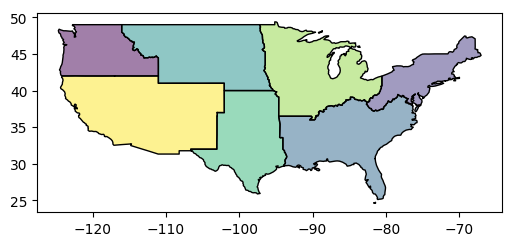

In [145]:
%matplotlib inline
regions.plot()


Our next task at hand is to create a mask (or rather, a set of index arrays) which can be used to subset the our P-Cat values by subregion. The approach we will involve generating another `GeoDataFrame` containing all of the grid point locations, grouping each point into another new `GeoDataFrame` based on whether or not they are inside the given subregion polygon.

In [146]:
# Sequence of grid point coordinates to be tested
points = [Point(x, y) for x, y in zip(lons.ravel(), lats.ravel())]
points = gpd.GeoDataFrame(geometry=points, crs=regions.crs)

# Since we now have a data frame for the grid points and for the polygons,
# we may now use sjoin() to merge them. The output is fundamentally a
# dictionary (keyed by subregion) which contains index arrays that
# subset the original data
regions
subsetted_points = sjoin(points, regions, how='left', op='within')
subsetted_points.dropna()[:10]

,geometry,index_right,region
454,POINT (-81 25.5),2.0,Southeast
455,POINT (-80.5 25.5),2.0,Southeast
543,POINT (-97.5 26),4.0,South Great Plains
575,POINT (-81.5 26),2.0,Southeast
576,POINT (-81 26),2.0,Southeast
577,POINT (-80.5 26),2.0,Southeast
662,POINT (-99 26.5),4.0,South Great Plains
663,POINT (-98.5 26.5),4.0,South Great Plains
664,POINT (-98 26.5),4.0,South Great Plains
665,POINT (-97.5 26.5),4.0,South Great Plains


We will now verify that the mask is consistent with a plot:

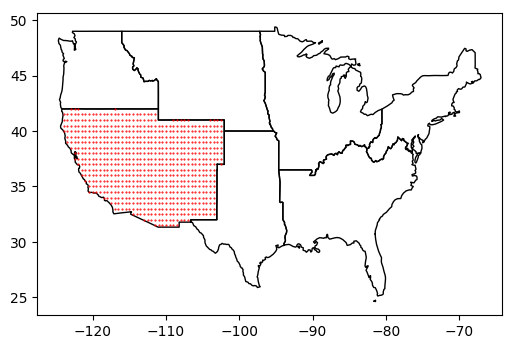

In [147]:
%matplotlib inline
ax = plt.gca()
regions.plot(ax=ax, alpha=0)
sw = subsetted_points[subsetted_points.region == 'Southwest']
sw.plot(ax=ax, color='r', markersize=.5)

The mask can be applied to the P-Cats as follows:

In [148]:
mask = subsetted_points.groupby('region').groups
pcatsw = pcats.values[:, mask['Southwest']]
pcatsw.shape

(2, 713)